<a href="https://colab.research.google.com/github/modichirag/flowpm/blob/master/notebooks/flowpm_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pylab inline
from flowpm import linear_field, lpt_init, nbody, cic_paint

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from scipy.interpolate import InterpolatedUnivariateSpline as iuspline

klin = np.loadtxt('../flowpm/data/Planck15_a1p00.txt').T[0]
plin = np.loadtxt('../flowpm/data/Planck15_a1p00.txt').T[1]

ipklin = iuspline(klin, plin)

Populating the interactive namespace from numpy and matplotlib
Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
import flowpm

stages = np.linspace(0.1, 1.0, 10, endpoint=True)

initial_conditions = flowpm.linear_field(128,         # size of the cube
                                         100,         # Physical size of the cube
                                         ipklin,      # Initial powerspectrum
                                         batch_size=1)

# Sample particles
state = flowpm.lpt_init(initial_conditions, a0=0.1)   

# Evolve particles down to z=0
final_state = flowpm.nbody(state, stages, 128)         

# Retrieve final density field
final_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), final_state[0])

with tf.Session() as sess:
    sim = sess.run(final_field)

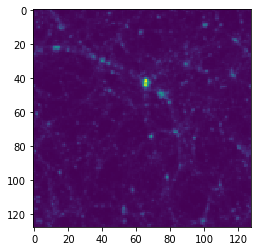

In [3]:
imshow(sim[0].sum(axis=0))

In [4]:
def _binomial_kernel(num_channels, dtype=tf.float32):
  """Creates a 5x5x5 b-spline kernel.
  Args:
    num_channels: The number of channels of the image to filter.
    dtype: The type of an element in the kernel.
  Returns:
    A tensor of shape `[5, 5, 5, num_channels, num_channels]`.
  """
  kernel = np.array((1., 4., 6., 4., 1.), dtype=dtype.as_numpy_dtype())
  kernel = np.einsum('ij,k->ijk', np.outer(kernel, kernel), kernel)
  kernel /= np.sum(kernel)
  kernel = kernel[:, :, :, np.newaxis, np.newaxis]
  return tf.constant(kernel, dtype=dtype) * tf.eye(num_channels, dtype=dtype)

def _downsample(cube, kernel):
  """Downsamples the image using a convolution with stride 2.
  """
  return tf.nn.conv3d(
      input=cube, filters=kernel, strides=[1, 2, 2, 2, 1], padding="SAME")
  
def _upsample(cube, kernel, output_shape=None):
  """Upsamples the image using a transposed convolution with stride 2.
  """
  if output_shape is None:
    output_shape = tf.shape(input=cube)
    output_shape = (output_shape[0], output_shape[1] * 2, output_shape[2] * 2,
                    output_shape[3] * 2, output_shape[4])
  return tf.nn.conv3d_transpose(
      cube,
      kernel * 2.0**3,
      output_shape=output_shape,
      strides=[1, 2, 2, 2, 1],
      padding="SAME")

def _build_pyramid(cube, sampler, num_levels):
  """Creates the different levels of the pyramid.
  """
  kernel = _binomial_kernel(1, dtype=cube.dtype)
  levels = [cube]
  for _ in range(num_levels):
    cube = sampler(cube, kernel)
    levels.append(cube)
  return levels

def _split(cube, kernel):
  """Splits the image into high and low frequencies.
  This is achieved by smoothing the input image and substracting the smoothed
  version from the input.
  """
  low = _downsample(cube, kernel)
  high = cube - _upsample(low, kernel, tf.shape(input=cube))
  return high, low

def downsample(cube, num_levels, name=None):
  """Generates the different levels of the pyramid (downsampling).
  """
  with tf.name_scope(name, "pyramid_downsample", [cube]):
    cube = tf.convert_to_tensor(value=cube)
    return _build_pyramid(cube, _downsample, num_levels)

def merge(levels, name=None):
  """Merges the different levels of the pyramid back to an image.
  """
  with tf.name_scope(name, "pyramid_merge", levels):
    levels = [tf.convert_to_tensor(value=level) for level in levels]
    cube = levels[-1]
    kernel = _binomial_kernel(tf.shape(input=cube)[-1], dtype=cube.dtype)
    for level in reversed(levels[:-1]):
      cube = _upsample(cube, kernel, tf.shape(input=level)) + level
    return cube

def split(cube, num_levels, name=None):
  """Generates the different levels of the pyramid.
  """
  with tf.name_scope(name, "pyramid_split", [cube]):
    cube = tf.convert_to_tensor(value=cube)

    kernel = _binomial_kernel(tf.shape(input=cube)[-1], dtype=cube.dtype)
    low = cube
    levels = []
    for _ in range(num_levels):
      high, low = _split(low, kernel)
      levels.append(high)
    levels.append(low)
    return levels

def upsample(cube, num_levels, name=None):
  """Generates the different levels of the pyramid (upsampling).
  """
  with tf.name_scope(name, "pyramid_upsample", [cube]):
    cube = tf.convert_to_tensor(value=cube)
    return _build_pyramid(cube, _upsample, num_levels)

In [55]:
field = tf.expand_dims(final_field, -1)

In [109]:
# Split field into short range and large scale components
levels = split(field, 1)

In [110]:
levels

[<tf.Tensor 'pyramid_split_5/sub:0' shape=(1, 128, 128, 128, 1) dtype=float32>,
 <tf.Tensor 'pyramid_split_5/Conv3D:0' shape=(1, 64, 64, 64, 1) dtype=float32>]

In [111]:
# Compute forces on both fields
def force(field):    
    shape = field.get_shape()
    batch_size, nc = shape[1], shape[2].value
    kfield = flowpm.utils.r2c3d(field)
    kvec = flowpm.kernels.fftk((nc, nc, nc), symmetric=False)
    
    
    lap = tf.cast(flowpm.kernels.laplace_kernel(kvec), tf.complex64)
    fknlrange = flowpm.kernels.longrange_kernel(kvec, 0)
    kweight = lap * fknlrange
    pot_k = tf.multiply(kfield, kweight)
    
    f = []
    for d in range(3):
      force_dc = tf.multiply(pot_k, flowpm.kernels.gradient_kernel(kvec, d))
      forced = flowpm.utils.c2r3d(force_dc)
      f.append(forced)
    
    return tf.stack(f, axis=-1)

In [112]:
force_levels = [force(levels[0][...,0]), force(levels[1][...,0])*2]

In [113]:
force_levels

[<tf.Tensor 'stack_22:0' shape=(1, 128, 128, 128, 3) dtype=float32>,
 <tf.Tensor 'mul_156:0' shape=(1, 64, 64, 64, 3) dtype=float32>]

In [114]:
rec = merge(force_levels)

In [115]:
rec

<tf.Tensor 'pyramid_merge_10/add:0' shape=(1, 128, 128, 128, 3) dtype=float32>

In [116]:
# Direct force computation on input field
dforce = force(field[...,0])

In [137]:
with tf.Session() as sess:
    sim, l0, l1,  r, df = sess.run([final_field, force_levels[0], force_levels[1], rec, dforce])

Text(0.5, 1.0, 'long range forces')

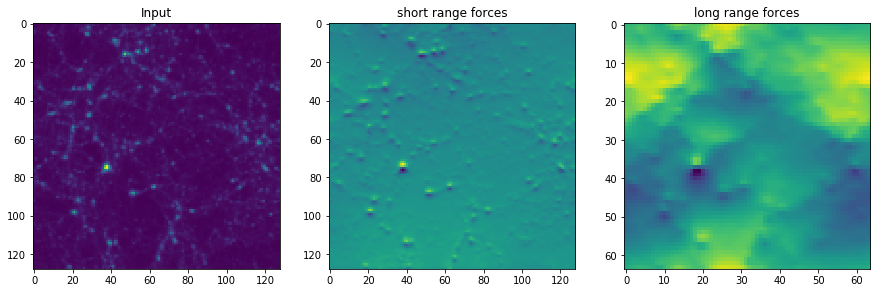

In [138]:
figure(figsize=(15,5))
subplot(131)
imshow(sim[0].sum(axis=1))
title('Input')
subplot(132)
imshow(l0[0].sum(axis=1)[...,0])
title('short range forces')
subplot(133)
imshow(l1[0].sum(axis=1)[...,0]);
title('l2')
title('long range forces')

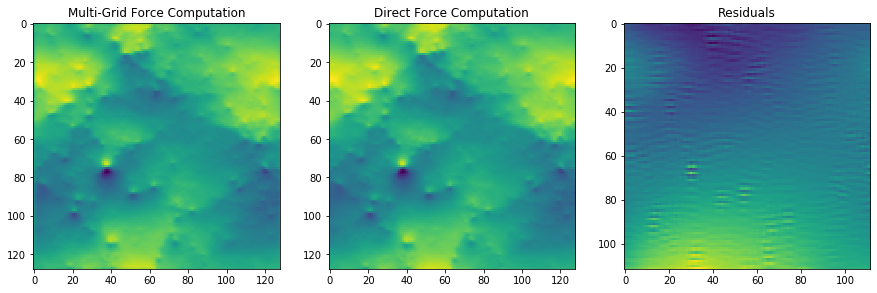

In [141]:
figure(figsize=(15,5))
subplot(131)
imshow(r[0].sum(axis=1)[...,0]);
title('Multi-Grid Force Computation')
subplot(132)
imshow(df[0].sum(axis=1)[...,0]);
title('Direct Force Computation')
subplot(133)
imshow((r - df)[0,8:-8,8:-8,8:-8].sum(axis=1)[...,0]); 
title('Residuals'); 

In [11]:
levels = split(field, 4)

In [12]:
rec = merge(levels)

In [8]:
with tf.Session() as sess:
    sim, l0, l1, l2, l3, r = sess.run([final_field, levels[0], levels[1], levels[2], levels[3], rec[...,0]])

Text(0.5, 1.0, 'approximation')

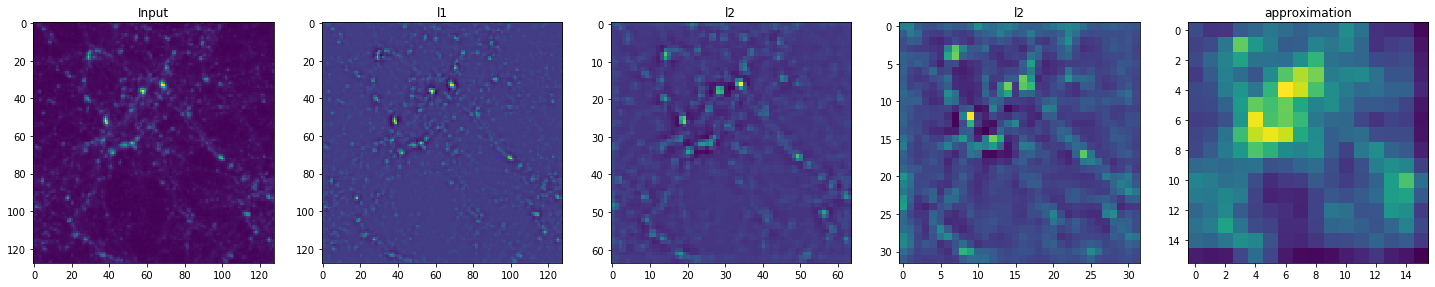

In [9]:
figure(figsize=(25,10))
subplot(151)
imshow(sim[0].sum(axis=0))
title('Input')
subplot(152)
imshow(l0[0].sum(axis=0)[...,0])
title('l1')
subplot(153)
imshow(l1[0].sum(axis=0)[...,0]);
title('l2')
subplot(154)
imshow(l2[0].sum(axis=0)[...,0]);
title('l2')
subplot(155)
imshow(l3[0].sum(axis=0)[...,0]);
title('approximation')

Text(0.5, 1.0, 'Difference')

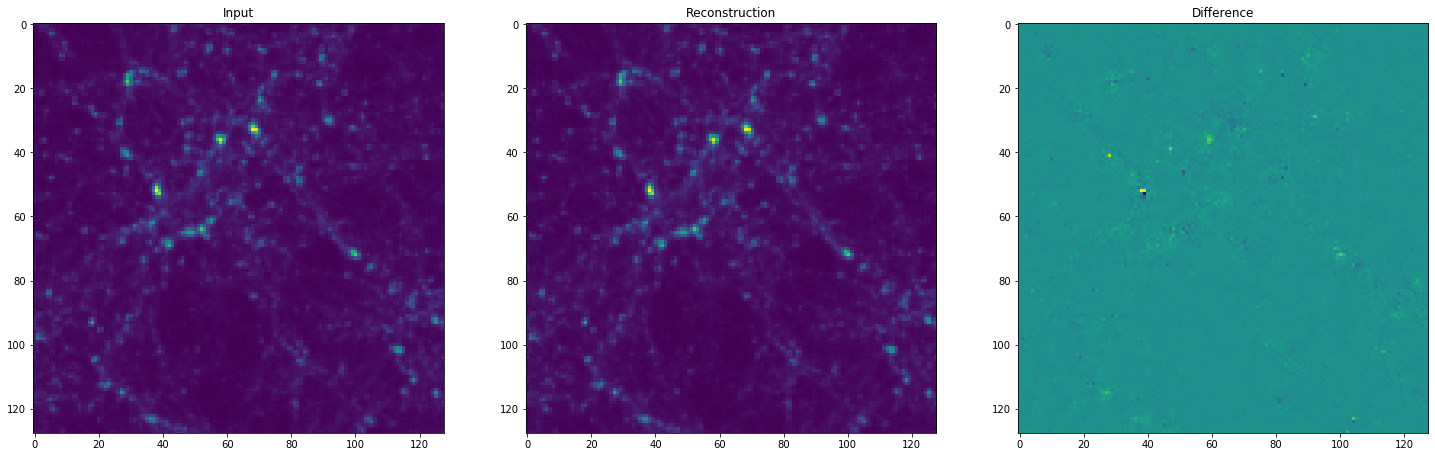

In [10]:
figure(figsize=(25,10))
subplot(131)
imshow(sim[0].sum(axis=0))
title('Input')
subplot(132)
imshow(r[0].sum(axis=0))
title('Reconstruction')
subplot(133)
imshow((sim - r)[0].sum(axis=0));
title('Difference')